In [1]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
from sklearn.metrics import classification_report
import sklearn
from Bio.Seq import Seq
np.random.seed(42)

Changes from previous version: I am implementing this with a HIV Dataset from GenBank. However, for now, many of the chains are "partial" labeled. Also, 66 anti-SARS-CoV-2 sequences made it into this set somehow. I manually deleted them.

In [2]:
# Note that row 10467 of the hiv-19 sequences was deleted due to having an empty HCDR3. The total number of hiv-19 samples is now 11,867

In [3]:
tf.__version__

'2.10.0'

# Preprocessing

In [4]:
# shutil.copy("../Data/HIV/heavy_seqs_aa.fasta", "../Data/HIV/heavy_seqs_aa.txt")
# OR
# Run the following too when new download
# awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < file.fa > out.txt
# Then, delete the first empty line

In [5]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 12534:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 12534


In [6]:
dummy = []
head = []
flag = False
with open("../Data/HIV/heavy_hiv.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        # if flag == True:
        #     flag = False
        #     continue
        # if i.find("partial") != -1:
        #     flag = True
        #     continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))
hiv_sequences = head

['QVQLVESGGGLVKPGGSLRLSCAASGFSFSDYYMSWIRQAPGKGLEWVSYIRSSGGSIYYADSVKGRFTIFWDNAKNSVLLQMNRLRAEDTAVYYCARGNGYWYFDLWGRGTLVTVSS\n', 'QVQLVESGGGVVQPGGSLRVSCAASGFRFSSYGMHWVRQAPGKGLEWVAFIRYDGSNRFYADSVKGRFTISRDNSKNTLYVQMNSLRAEDTAVYYCAKEGNWNDLKYHFDHWGQGTLVSVSS\n', 'QVQLVQSGAEVKKPGASVKVSCKASGYTFASYAISWVRQAPGQGPEWMGWISAYSGDTKYVQFLQGRVTITTDTSTSTASMELRSLRSDDTAVYYCARALHPVTIFGVGCLDSWGQGTLVTVSS\n', 'EVQLVESGGGLEQPGRSLSLSCAASGFSFGEYAMSWVRQAPGKGLEWVGFIRSKAYGGTTEYAASVKGRVTISRDDSRSIAYLQMNSLKTEDTAVYYCARGASLEWLLSVSDYYYMDVWGKGTTVTVSS\n', 'EVRLVQSGAVLRKPGSSVKISCRASGYDFREISLHWVRLTPARGFEWIGWIKPRWGAVGYARQLQGRVTLTRQLSQDPDDPDWGIGYMELSGLTSADSAEYFCVRRGPCDYCGDFVWQYWGQGTVVVVS\n'] 12534


In [7]:

# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(hiv_sequences, key=len)))
# print(hiv_sequences)

138
138


In [8]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [9]:
hiv_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in hiv_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((138, 20))
    print(i)
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    hiv_onehot.append(b)

# print(hiv_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((138, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(hiv_onehot))

# set infected 1, healthy 0

QVQLVESGGGLVKPGGSLRLSCAASGFSFSDYYMSWIRQAPGKGLEWVSYIRSSGGSIYYADSVKGRFTIFWDNAKNSVLLQMNRLRAEDTAVYYCARGNGYWYFDLWGRGTLVTVSS
QVQLVESGGGVVQPGGSLRVSCAASGFRFSSYGMHWVRQAPGKGLEWVAFIRYDGSNRFYADSVKGRFTISRDNSKNTLYVQMNSLRAEDTAVYYCAKEGNWNDLKYHFDHWGQGTLVSVSS
QVQLVQSGAEVKKPGASVKVSCKASGYTFASYAISWVRQAPGQGPEWMGWISAYSGDTKYVQFLQGRVTITTDTSTSTASMELRSLRSDDTAVYYCARALHPVTIFGVGCLDSWGQGTLVTVSS
EVQLVESGGGLEQPGRSLSLSCAASGFSFGEYAMSWVRQAPGKGLEWVGFIRSKAYGGTTEYAASVKGRVTISRDDSRSIAYLQMNSLKTEDTAVYYCARGASLEWLLSVSDYYYMDVWGKGTTVTVSS
EVRLVQSGAVLRKPGSSVKISCRASGYDFREISLHWVRLTPARGFEWIGWIKPRWGAVGYARQLQGRVTLTRQLSQDPDDPDWGIGYMELSGLTSADSAEYFCVRRGPCDYCGDFVWQYWGQGTVVVVS
QLVLTQSPSTSASLGASVKLTCTLSSGHNNYAVAWHQHQAEKGPRFLMEVKSDGGHNKGDGVPDRFSGSSSGAECYLTISSLQSEDEADYYCQTWGTGIVVFGGGTKLTVL
SGTLSLTCSVSGVSMSGYYWSWIRQPPGKGLEWIGYMYYAGSSNYNPSLKSRVTIEVDTSEEQFSLKVRSVTTADTAVYYCAALPRGQLVNAYFHHWGQGTLVTVSP
EVQLVESGGGLIQPGGSLRVSCAASGFSVSGKYMSWVRQAPGKGLEWVSVIYSGGSTYYGDSVKGRFTFSRDNSKNTLYLQMNSLRVEDTAVYYCARGISSYSAFDIWGQGTLVTVSF
EVQLVESGGGLVPPGRSLRLSCVASGFTFGDYAM

In [10]:
healthy_lables = [0] * 12534
hiv_lables = [1] * 12534

In [11]:
X = np.concatenate((healthy_onehot, hiv_onehot))
y = np.concatenate((healthy_lables, hiv_lables))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [13]:
print(X_train)
print(y_train)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[0 1 0 ...

# Model

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(138, 20)),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-12-10 21:17:26.679456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 21:17:26.679578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=25, validation_data = (X_val, y_val))

Epoch 1/25


2022-12-10 21:17:27.043301: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 21:17:27.454079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


635/635 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.7703

2022-12-10 21:17:35.777819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


635/635 [==============================] - 9s 13ms/step - loss: 0.4110 - accuracy: 0.7703 - val_loss: 0.3309 - val_accuracy: 0.8285
Epoch 2/25
635/635 [==============================] - 8s 12ms/step - loss: 0.3195 - accuracy: 0.8403 - val_loss: 0.3110 - val_accuracy: 0.8463
Epoch 3/25
635/635 [==============================] - 8s 13ms/step - loss: 0.2813 - accuracy: 0.8675 - val_loss: 0.3148 - val_accuracy: 0.8409
Epoch 4/25
102/635 [===>..........................] - ETA: 6s - loss: 0.2371 - accuracy: 0.8971

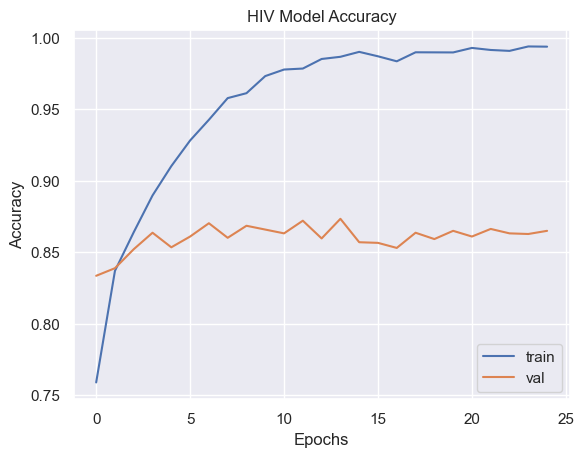

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('HIV Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Testing

In [ ]:
model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 6ms/step - loss: 1.1908 - accuracy: 0.8576


[1.1907843351364136, 0.8575987219810486]

In [ ]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 14ms/step


2022-12-10 21:09:51.982097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

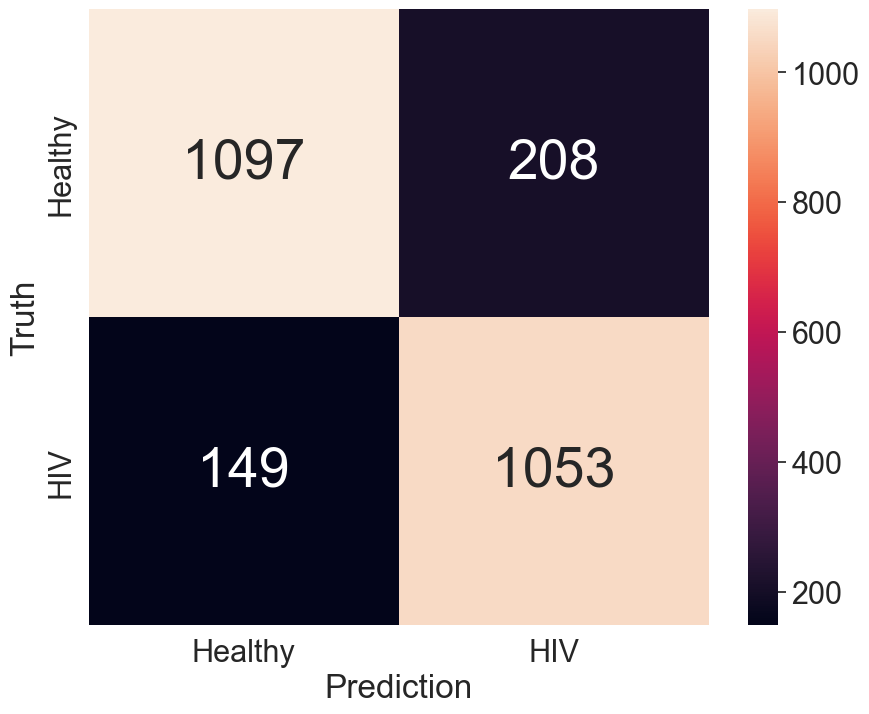

tf.Tensor(
[[1097  208]
 [ 149 1053]], shape=(2, 2), dtype=int32)


In [ ]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "HIV"],
            yticklabels=["Healthy", "HIV"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [ ]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

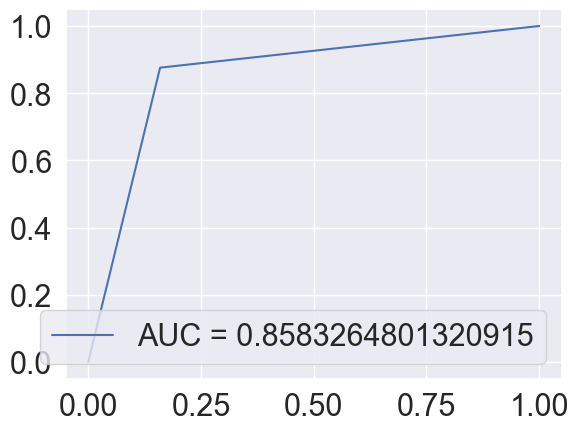

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()